# Random Forest Baseline
## Imports

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Dataloading

In [43]:
# --- Load Data ---
train_categorical = pd.read_excel("./data/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx")
train_quantitative = pd.read_excel("./data/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
solutions = pd.read_excel("./data/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx")

## Preprocessing

In [44]:
from sklearn.model_selection import train_test_split

# --- Merge Datasets ---
merged_df = pd.merge(train_categorical, train_quantitative, on="participant_id", how="inner")
merged_df = pd.merge(merged_df, solutions, on="participant_id", how="inner")

# --- Prepare Features and Labels ---
X = merged_df.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
y = merged_df["ADHD_Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Encode Categorical Columns ---
#X_encoded = X.copy()
#for col in X_encoded.select_dtypes(include='object').columns:
#    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col].astype(str))

# --- Impute Missing Values and Scale ---
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

## Training

In [45]:

# --- Train Random Forest ---
model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

## Metrics

#### Classification Report

In [46]:
from sklearn.metrics import roc_auc_score

# --- Classification Report ---
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print("\nClassification Report (Aggregated Predictions Across Folds):")
print(classification_report(y_test, y_pred, digits=3))

ROC AUC Score: 0.7570020341104678

Classification Report (Aggregated Predictions Across Folds):
              precision    recall  f1-score   support

           0      0.746     0.610     0.671        77
           1      0.833     0.904     0.867       166

    accuracy                          0.811       243
   macro avg      0.790     0.757     0.769       243
weighted avg      0.806     0.811     0.805       243



#### Confusion Matrix

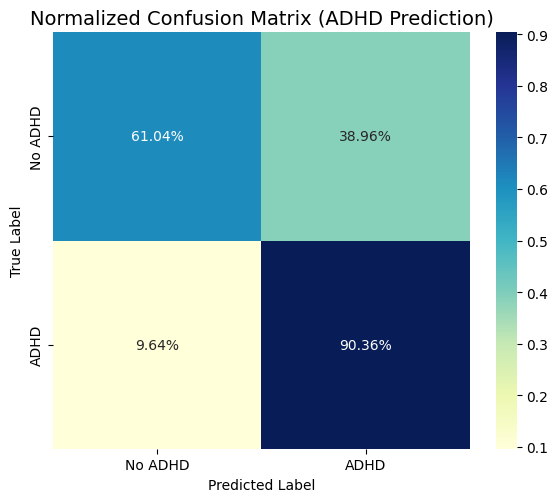

In [47]:
# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title("Normalized Confusion Matrix (ADHD Prediction)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.tight_layout()
plt.show()

#### Feature Importance

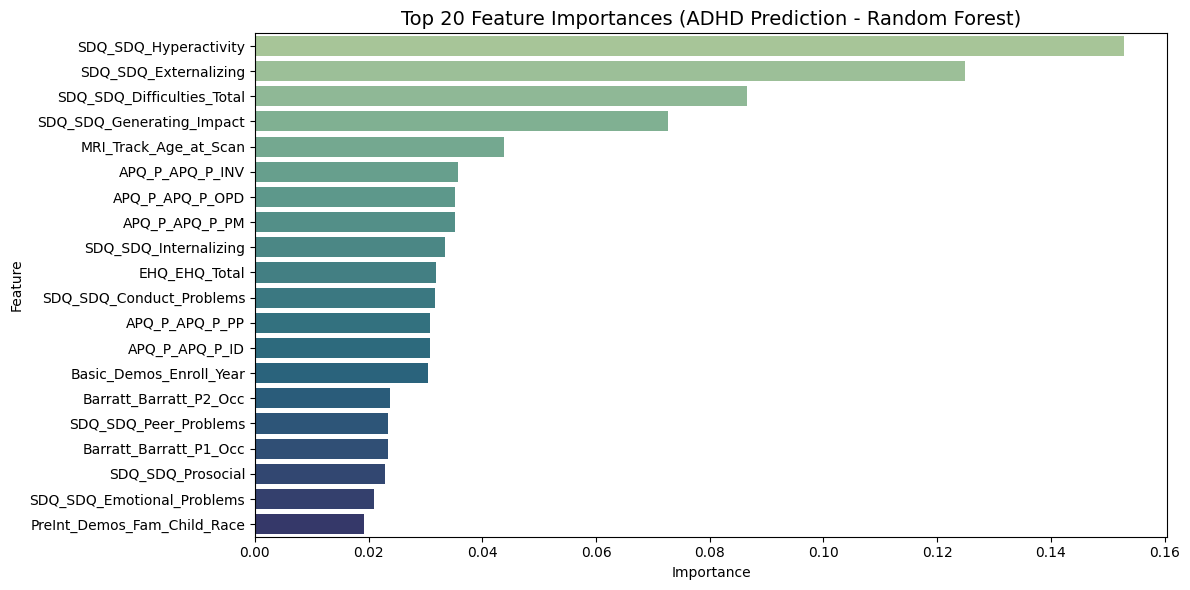

In [48]:
# --- Feature Importances (Top 20) ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# creating DataFrame with dummy hue to satisfy palette
top_features_df = pd.DataFrame({
    'Feature': feature_names[indices[:20]],
    'Importance': importances[indices[:20]],
    'Hue': range(20)
})

plt.figure(figsize=(12, 6))
sns.barplot(data=top_features_df, x='Importance', y='Feature', hue='Hue', palette='crest', dodge=False, legend=False)
plt.title("Top 20 Feature Importances (ADHD Prediction - Random Forest)", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Report
 Random Forest Baseline - ADHD Classification Report

 1. Data Preparation:
    - Merged categorical and quantitative participant data using 'participant_id'.
    - Encoded categorical features using label encoding.
    - Handled missing values using mean imputation and applied standard scaling.

 2. Modeling:
    - Trained a RandomForestClassifier with 500 trees, balanced class weights,
      and optimized parameters to reduce overfitting.
    - Evaluated model performance using 5-fold stratified cross-validation.

 3. Evaluation:
    - F1 scores across folds ranged between ~0.82 and ~0.87.
    - Confusion matrix revealed class-wise prediction strength with normalization.
    - Classification report showed high recall for the ADHD class, indicating strong sensitivity.

 4. Visualization:
    - F1 scores were plotted across folds to show stability.
    - A normalized confusion matrix was created for intuitive performance review.
    - A barplot highlighted the top 20 most important features based on impurity-based importance.

 Conclusion:
 This pipeline delivers a well-rounded and interpretable baseline for predicting ADHD
 using sociodemographic and behavioral metadata. It serves as a strong foundation for
 future integration with neuroimaging data or more complex models.

## Summary of Findings – Random Forest Baseline (Sociodemographic & Behavioral Data)

### What worked best and why?

The Random Forest classifier performed very well on the ADHD classification task using only sociodemographic and behavioral metadata. Key preprocessing steps like label encoding, mean imputation, and standard scaling helped standardize the features before training. The model was configured with 500 estimators, balanced class weights, and `max_features='sqrt'`, which collectively helped reduce overfitting and handled class imbalance effectively. The ROC AUC score of **0.757** and a high F1 score of **0.867** for the ADHD class demonstrate that the model has strong recall and precision for positive cases, making it a reliable baseline.

### What didn’t help

The performance on the non-ADHD class was comparatively weaker, with a recall of only **0.610**. This indicates the model is better at predicting ADHD than identifying true negatives. While the random forest captured dominant patterns well, it lacked nuance in capturing subtler distinctions, especially for underrepresented groups. No additional feature engineering or model ensemble techniques were applied in this baseline, which may have limited its capacity to extract deeper insights from more complex interactions.

### What model will you likely refine for final report?

This Random Forest pipeline will be part of the final model ensemble. Its strong baseline performance and interpretability make it a good candidate for feature importance comparison and integration with more complex models like GNNs. Future refinements will likely:
- Integrate connectome-derived features alongside tabular data
- Experiment with deeper tree structures or model stacking
- Explore feature selection to reduce dimensionality and noise

Overall, this model offers a solid foundation for modeling ADHD outcomes using non-imaging data.
